Adapting Code from Connectivity Combined results and Analayse Efficient Feats Results to plot graphs

In [2]:
import pandas as pd
import mne as mne
import os 
import time
import numpy as np
import matplotlib.pyplot as plt
import joblib
import constants
from IPython.utils import io
import time
import sys
import yasa
from scipy.signal import welch

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score

import matplotlib.patches as mpatches

#Import my modules
import format_eeg_data
import constants
import eeg_stat_ts
import run_expts

#TS Fresh Parameter Settings
from tsfresh.feature_extraction import ComprehensiveFCParameters
from tsfresh.feature_extraction import MinimalFCParameters
from tsfresh.feature_extraction import EfficientFCParameters
from tsfresh.feature_extraction import extract_features

# Set display options to show all rows and columns
pd.set_option('display.max_rows', 50)  # Show rows
pd.set_option('display.max_columns', 160)  # Show columns

/user/home/ko20929/.conda/envs/sktime_latest/lib/python3.11/site-packages/antropy/fractal.py:197: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit((types.Array(types.float64, 1, "C", readonly=True), types.int32))


In [ ]:
'All_results_bpw_feats_minimal_TS_Fresh.pkl'

### Load the results dictionary to plot

Load whichever results dictionary you want and aslong as it's loaded correctly this code should be able to plot it

In [3]:
# This code loads the data from a bpw and max freq combined statistics
core_path = '/user/home/ko20929/work/RBD_using_custom_package/Execute New Experiments/Baseline_Extensions/Combine_Max_Freq_Power_Band/'
file_name = 'All_results_bpw_plus_max_freq_efficient_TS_Fresh.pkl'
file_name_2 = 'All_results_bpw_plus_max_freq_minimal_TS_Fresh.pkl'

loaded_dict = joblib.load(core_path + file_name_2)

loaded_dict = joblib.load('All_results_bpw_feats_minimal_TS_Fresh.pkl')

results = loaded_dict
results_type = 'minimal'

In [4]:
results[1]['Wake'].keys()

dict_keys(['regional', 'regions_combined', 'all_feats'])

### Create results dataframe and fill with data

In [20]:
expt_info = [ '1. PD vs HC', '2. (PD , PD+RBD) vs HC', '3. (PD + PD&RBD) vs HC vs RBD', 
             '4. PD vs PD+RBD vs RBD vs HC' ]

df_cols = ['Expt_type_num',  'Classifier', 'EEG Type', 'Region', 'TS_Fresh_setting', 'Accuracy', 'Accuracy_std' , 'features']
df_dict = {}
for col in df_cols:
     df_dict[col] = []

In [7]:
#The results dataframe that I will plot from will contain
#Expt_num , #Clf name  , #Region , #Features Used , #EEG Type

key_errors = [] #Track which cols are not present in dataframe

data_types = ['Wake','N1', 'N2', 'N3', 'REM']

regions = constants.regions

combined_regions = []
for i, region_1 in enumerate(regions):
    for region_2 in regions[i+1:]:
        new_key = region_1 + '_' + region_2
        combined_regions.append(new_key)

for expt_num in [1,2,3,4]:
    for features in ['regional' , 'regions_combined' , 'all_feats']:
        for data_type in data_types:
            results_df = results[expt_num][data_type][features]
            res_df = run_expts.generate_subset_acc_std(results_df, return_df = True)
            mean_res_df = pd.DataFrame( res_df.mean(axis = 0)).T
            if features == 'regional': 
                for region in regions:
                    for clf in ['Ada_B' , 'DT' , 'RF' , 'SVC' ]:
                        col_name = region + '_' + clf
                        # + 'acc' , + 'std'
                        try:
                            df_dict['Accuracy'].append(mean_res_df[col_name + '_acc'].values[0])
                            df_dict['Accuracy_std'].append(mean_res_df[col_name + '_std'].values[0])
                            df_dict['Expt_type_num'].append(expt_num)
                            df_dict['Classifier'].append(clf)
                            df_dict['EEG Type'].append(data_type)
                            df_dict['Region'].append(region)
                            df_dict['TS_Fresh_setting'].append('Minimal')
                           
                            df_dict['features'].append(features)
                        except KeyError:
                            key_errors.append(col_name)
                        
            elif features == 'regions_combined':
                for region in combined_regions:
                    for clf in ['Ada_B' , 'DT' , 'RF' , 'SVC' ]:
                        col_name = region + '_' + clf
                        # + 'acc' , + 'std'
                        try:
                            df_dict['Accuracy'].append(mean_res_df[col_name + '_acc'].values[0])
                            df_dict['Accuracy_std'].append(mean_res_df[col_name + '_std'].values[0])
                            df_dict['Expt_type_num'].append(expt_num)
                            df_dict['Classifier'].append(clf)
                            df_dict['EEG Type'].append(data_type)
                            df_dict['Region'].append(region)
                            df_dict['TS_Fresh_setting'].append('Minimal')
                            df_dict['features'].append(features)
                        except KeyError:
                            key_errors.append(col_name)
                        
            elif features == 'all_feats': 
                pass
            else:
                print('features value is not correct!')
                pass

        
full_results_df = pd.DataFrame(df_dict)

In [14]:
full_results_df.head()

,Expt_type_num,Classifier,EEG Type,Region,TS_Fresh_setting,Accuracy,Accuracy_std,features
0,1,Ada_B,Wake,Prefrontal,Minimal,0.550000,0.147345,regional
1,1,DT,Wake,Prefrontal,Minimal,0.600000,0.171718,regional
2,1,RF,Wake,Prefrontal,Minimal,0.616667,0.138007,regional
3,1,Ada_B,Wake,Frontal,Minimal,0.783333,0.119371,regional
4,1,DT,Wake,Frontal,Minimal,0.750000,0.158114,regional


#### Plot the results [regional]

In [16]:
results_df = full_results_df[full_results_df['features'] == 'regional']

In [17]:
results_df[(results_df['Region'] == 'Prefrontal') & (results_df['Expt_type_num'] == 1)  & (results_df['EEG Type'] == 'Wake')]

,Expt_type_num,Classifier,EEG Type,Region,TS_Fresh_setting,Accuracy,Accuracy_std,features
0,1,Ada_B,Wake,Prefrontal,Minimal,0.550000,0.147345,regional
1,1,DT,Wake,Prefrontal,Minimal,0.600000,0.171718,regional
2,1,RF,Wake,Prefrontal,Minimal,0.616667,0.138007,regional


In [21]:
results_type = 'minimal'

<Figure size 640x480 with 0 Axes>

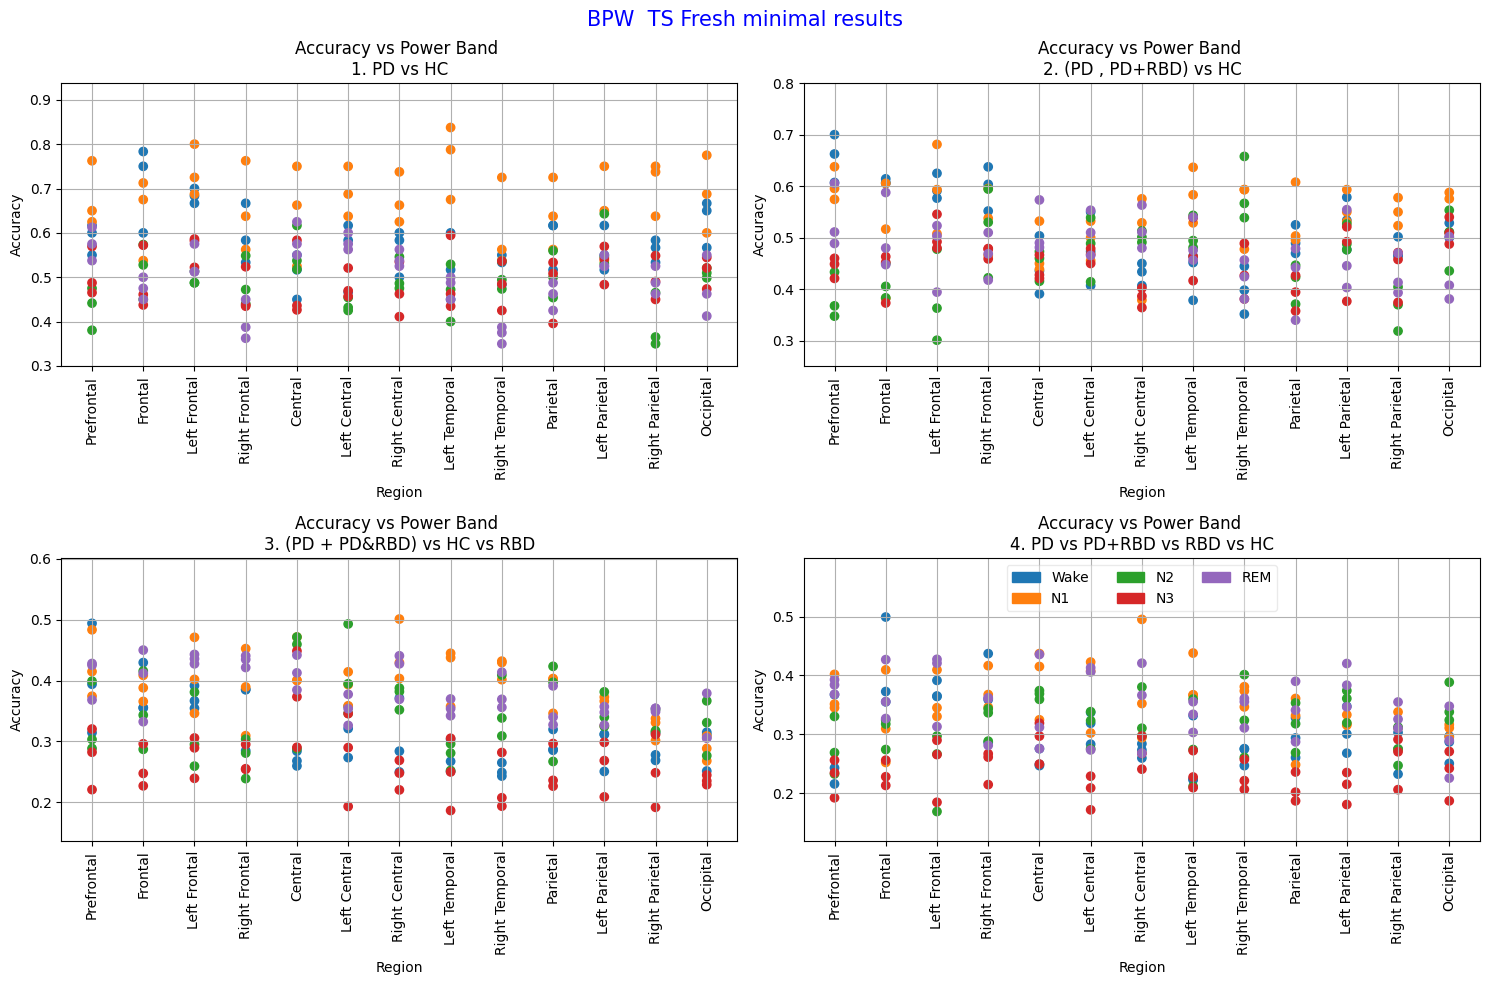

<Figure size 640x480 with 0 Axes>

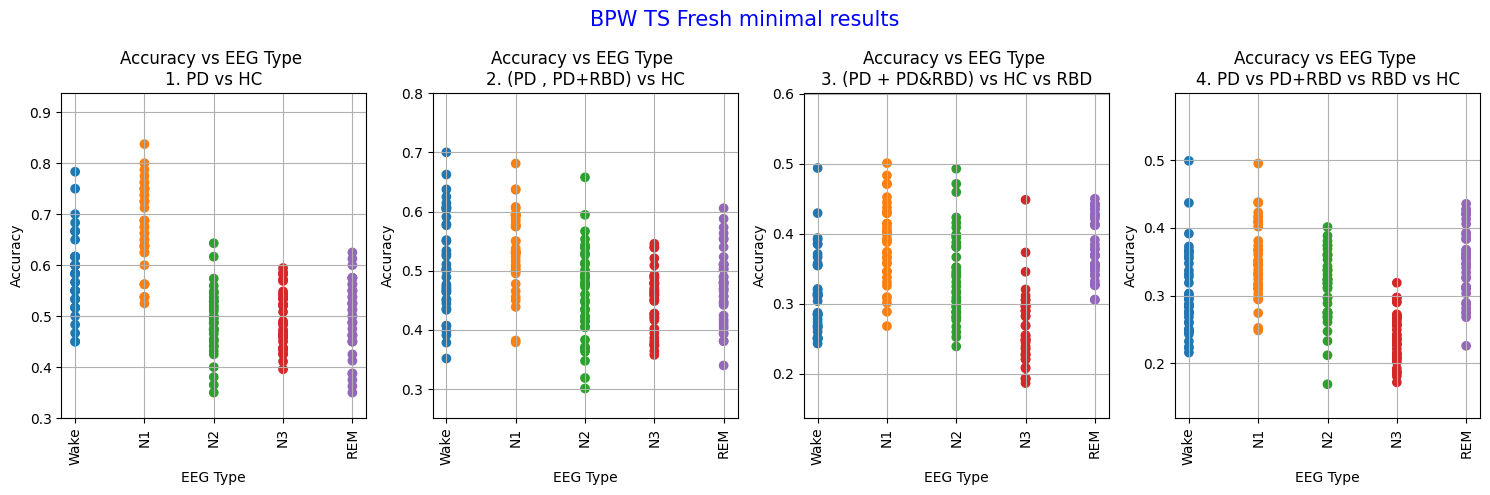

In [23]:
fig = plt.figure()
fig = plt.figure(figsize=(15,10),dpi=100)

for i in [1,2,3,4]:
    expt_num = i
    expt_results = results_df[results_df['Expt_type_num'] == expt_num].copy()
    expt_results.sort_values(by=['Region','Accuracy'], ascending = False)
    
    ax = fig.add_subplot(2,2,i)
    
    plt.title('Accuracy vs Power Band \n' + expt_info[expt_num-1])
    
    #Define colours for the different data types
    colors = {'Wake':'tab:blue', 'N1':'tab:orange', 'N2':'tab:green', 'N3':'tab:red', 'REM':'tab:purple'}
    plt.scatter(expt_results['Region'].values, expt_results['Accuracy'].values,
                    c = expt_results['EEG Type'].map(colors)) 
   
    plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees
    plt.xlabel('Region')
    plt.ylabel('Accuracy')
    plt.ylim((expt_results['Accuracy'].min() - 0.05 , expt_results['Accuracy'].max() + 0.1))
    plt.grid()

    plt.tight_layout()

#Custom Legend, because standard legend wouldn't work for some reason
patches = []
for key, val in colors.items():
    patches.append(mpatches.Patch(color= val, label=key) )

# plt.legend(handles=patches, framealpha = 0.1)
plt.legend(loc = 'upper center', ncol = 3 ,  handles=patches, framealpha = 0.4)

plt.suptitle('BPW  TS Fresh ' + results_type + ' results', size = 15, color = 'blue')    
plt.tight_layout()
plt.savefig('Figures/bpw_' + results_type +'_feats_regional.png', dpi=200) 



#Do the plots again for data type accuracy distribution
fig = plt.figure()
fig = plt.figure(figsize=(15,5),dpi=100)

for i in [1,2,3,4]:
    expt_num = i
    expt_results = results_df[results_df['Expt_type_num'] == expt_num].copy()
    expt_results.sort_values(by=['Region','Accuracy'], ascending = False)
    
    ax = fig.add_subplot(1,4,i)
    
    plt.title('Accuracy vs EEG Type \n' + expt_info[expt_num-1])
    
    #Define colours for the different data types
    colors = {'Wake':'tab:blue', 'N1':'tab:orange', 'N2':'tab:green', 'N3':'tab:red', 'REM':'tab:purple'}
    plt.scatter(expt_results['EEG Type'].values, expt_results['Accuracy'].values,
                    c = expt_results['EEG Type'].map(colors))

   
    plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees
    plt.xlabel('EEG Type')
    plt.ylabel('Accuracy')
    plt.ylim((expt_results['Accuracy'].min() - 0.05 , expt_results['Accuracy'].max() + 0.1))
    plt.grid()

    plt.tight_layout()
    
plt.suptitle('BPW TS Fresh ' + results_type + ' results', size = 15, color = 'blue')
plt.tight_layout()
plt.savefig('Figures/bpw_' + results_type +'_feats_regional_data_type.png', dpi=200) 

#### Plot the results [Dual Region]

In [27]:
#Create a dictionary which is each region : associated combined region column names 
#Us that dictionary to do a regional cut of the above combined regions data ... safe . #gainz

combined_regions_mapping_dict = {}
for region in regions:
    combined_regions_mapping_dict[region] = []

#mapping from individual regions to the corresponding combined regions fam
for i, region_1 in enumerate(regions):
    for region_2 in regions[i+1:]:
        new_key = region_1 + '_' + region_2
        combined_regions_mapping_dict[region_1].append(new_key)
        combined_regions_mapping_dict[region_2].append(new_key)

In [28]:
# Function to find keys for a given value
def find_keys(dictionary, target_value):
    return [key for key, value_list in dictionary.items() if target_value in value_list]

In [29]:
results_df = full_results_df[full_results_df['features'] == 'regions_combined']

<Figure size 640x480 with 0 Axes>

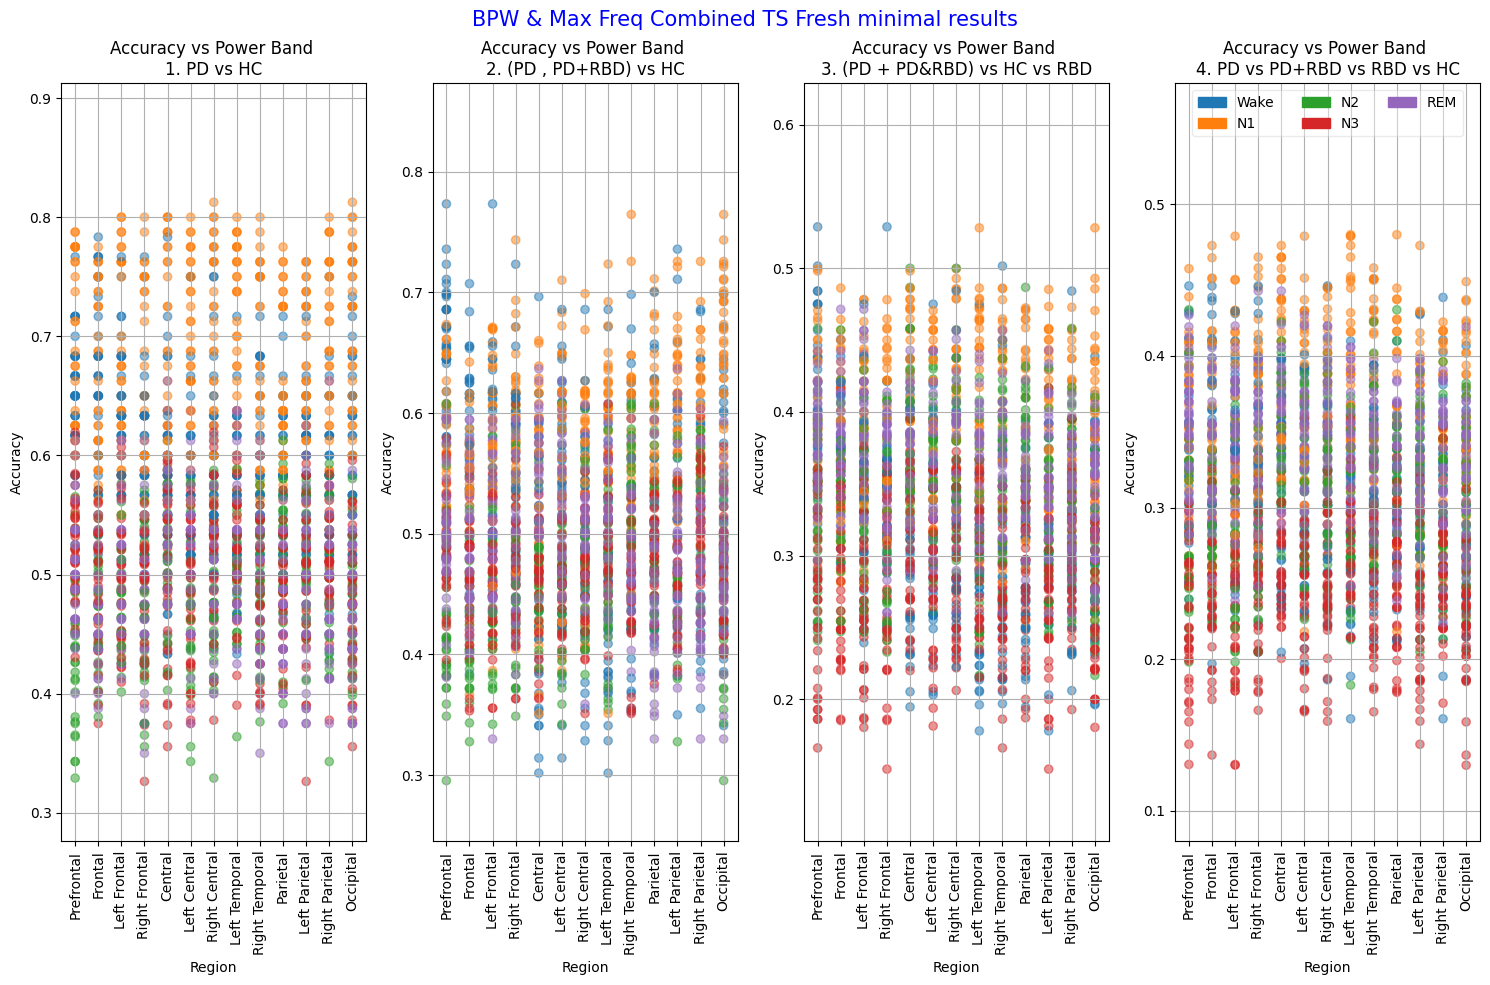

<Figure size 640x480 with 0 Axes>

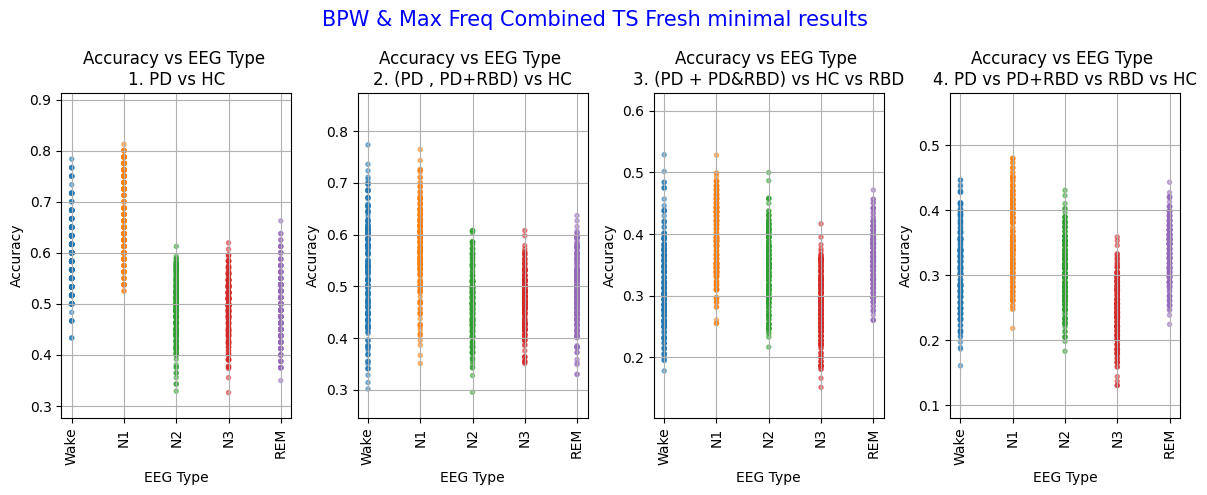

In [30]:
fig = plt.figure()
fig = plt.figure(figsize=(15,10),dpi=100)

for i in [1,2,3,4]:
    expt_num = i
    expt_results = results_df[results_df['Expt_type_num'] == expt_num].copy()
    expt_results.sort_values(by=['Region','Accuracy'], ascending = False)
    
    ax = fig.add_subplot(1,4,i)
    
    plt.title('Accuracy vs Power Band \n' + expt_info[expt_num-1])
    
    #Define colours for the different data types
    colors = {'Wake':'tab:blue', 'N1':'tab:orange', 'N2':'tab:green', 'N3':'tab:red', 'REM':'tab:purple'}
     
    list_1 = []
    list_2 = []
    for val in list(expt_results['Region'].values):
        list_1.append(find_keys(combined_regions_mapping_dict, val)[0])
        list_2.append(find_keys(combined_regions_mapping_dict, val)[1])

    plt.scatter(np.array(list_1), expt_results['Accuracy'].values,
                    c = expt_results['EEG Type'].map(colors) , alpha = 0.5) 

    plt.scatter(list_2, expt_results['Accuracy'].values,
                    c = expt_results['EEG Type'].map(colors), alpha = 0.5) 

   
    plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees
    plt.xlabel('Region')
    plt.ylabel('Accuracy')
    plt.ylim((expt_results['Accuracy'].min() - 0.05 , expt_results['Accuracy'].max() + 0.1))
    plt.grid()

    plt.tight_layout()

#Custom Legend, because standard legend wouldn't work for some reason
patches = []
for key, val in colors.items():
    patches.append(mpatches.Patch(color= val, label=key) )

# plt.legend(handles=patches, framealpha = 0.1)
plt.legend(loc = 'upper center', ncol = 3 ,  handles=patches, framealpha = 0.4)
    
plt.suptitle('BPW & Max Freq Combined TS Fresh ' + results_type + ' results', size = 15, color = 'blue')    
plt.tight_layout()
plt.savefig('Figures/bpw_max_freq_combined_' + results_type +'_feats_dual_regional.png', dpi=200) 



#Do the plots again for data type accuracy distribution
fig = plt.figure()
fig = plt.figure(figsize=(12,5),dpi=100)

for i in [1,2,3,4]:
    expt_num = i
    expt_results = results_df[results_df['Expt_type_num'] == expt_num].copy()
    expt_results.sort_values(by=['Region','Accuracy'], ascending = False)
    
    ax = fig.add_subplot(1,4,i)
    
    plt.title('Accuracy vs EEG Type \n' + expt_info[expt_num-1])
    
    #Define colours for the different data types
    colors = {'Wake':'tab:blue', 'N1':'tab:orange', 'N2':'tab:green', 'N3':'tab:red', 'REM':'tab:purple'}
    plt.scatter(expt_results['EEG Type'].values, expt_results['Accuracy'].values,
                    c = expt_results['EEG Type'].map(colors), alpha = 0.5, marker = '.')

   
    plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees
    plt.xlabel('EEG Type')
    plt.ylabel('Accuracy')
    plt.ylim((expt_results['Accuracy'].min() - 0.05 , expt_results['Accuracy'].max() + 0.1))
    plt.grid()

    plt.tight_layout()

plt.suptitle('BPW & Max Freq Combined TS Fresh ' + results_type + ' results', size = 15, color = 'blue')
plt.tight_layout()
plt.savefig('Figures/bpw_max_freq_combined_' + results_type +'_dual_regional_data_type.png', dpi=200) 
